# Twitter and US Airlines
This is an exercice of text analysis, more precisely sentiment analysis, it would be wiser to use supervized models.
There are many machine learning algorithms used in text classification. The most frequently used are the Naive Bayes family of algorithms (NB), Support Vector Machines (SVM), and deep learning algorithms.
I'm not sure there are enough data for the last approach, so I'll start with a NB model first.

## Summary 
1. Libraries and Data Loading
2. Data Preprocessing 
    1. Suppression of redundant columns
    2. Preprocessing of the column 'text'
3. Data Vizualisation
    1. Tweets count by sentiment
    2. Visualisation of the most frequent words by sentiment
    3. Sentiment and text length
4. Comparison of a few supervized model
    1. NB
    2. SVM
    3. AdaBoost
    4. KN

## 1. Libraries and Data Loading

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt

In [2]:
cnx = sqlite3.connect('database.sqlite')
data = pd.read_sql_query("SELECT * FROM Tweets", cnx)
data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  567588278875213824           neutral                           1.0   
1  567590027375702016          negative                           1.0   
2  567591480085463040          negative                           1.0   
3  567592368451248130          negative                           1.0   
4  567594449874587648          negative                           1.0   

           negativereason negativereason_confidence    airline  \
0                                                        Delta   
1              Can't Tell                    0.6503      Delta   
2             Late Flight                     0.346     United   
3             Late Flight                         1     United   
4  Customer Service Issue                    0.3451  Southwest   

  airline_sentiment_gold         name negativereason_gold  retweet_count  \
0                         JetBlueNews                                  0   
1                           nesi_1992                                  0   
2                           CPoutloud                                  0   
3                            brenduch                                  0   
4                            VahidESQ                                  0   

                                                text tweet_coord  \
0  @JetBlue's new CEO seeks the right balance to ...               
1  @JetBlue is REALLY getting on my nerves !! 😡😡 ...               
2  @united yes. We waited in line for almost an h...               
3  @united the we got into the gate at IAH on tim...               
4  @SouthwestAir its cool that my bags take a bit...               

               tweet_created   tweet_location               user_timezone  
0  2015-02-16 23:36:05 -0800              USA                      Sydney  
1  2015-02-16 23:43:02 -0800        undecided  Pacific Time (US & Canada)  
2  2015-02-16 23:48:48 -0800   Washington, DC                              
3  2015-02-16 23:52:20 -0800                                 Buenos Aires  
4  2015-02-17 00:00:36 -0800  Los Angeles, CA  Pacific Time (US & Canada)

## 2. Data Preprocessing
### A. Suppression of redundant columns
#### Columns:

In [3]:
list(data.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

Our goal is to predict the sentiment of a tweet. Let's examine the usefulness of each column:

1. 'tweet_id' : not useful 
2. 'airline_sentiment' : prediction target
3. 'airline_sentiment_confidence' : feature
4. 'negativereason' : 37% missing values
5. 'negativereason_confidence' :  
6. 'airline': not relevant
7. 'airline_sentiment_gold': 100% missing values 
8. 'name': not useful
9. 'negativereason_gold' : 100% missing values
10. 'retweet_count': not relevant
11. 'text' : feature
12. 'tweet_coord': 93% missing values
13. 'tweet_created : not useful
14. 'tweet_location': not useful
15. 'user_timezone' : not useful
#### At first, we will use the following features : 
1. Airline_sentiment, 
2. Airline_sentiment_confidence,  
3. Text

Transformation of the dataset to keep only  interesting columns:

In [4]:
data.columns
data = data[['airline_sentiment','airline_sentiment_confidence','text']]
data['length_text'] = data['text'].apply(len)

We can now proceed to preprocessing, with a dataset containing the following columns: ['airline_sentiment','airline_sentiment_confidence','text', 'length_text']


## 2. Data Preprocessing

## Cleaning the 'text' column
We must clean the texts from the words providing little information on the sentiment of the tweet, like for example :
1. Stopwords like "and", "the", "for", "in", 'it", etc.
2. Twitter account id, i.e. the word with the prefix "@"
3. URLs
### a. Removal of mentions and URLs


Libraries import 

In [5]:
import string
import re
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords

Function cleaning the tweets of unecessary content: 

In [6]:
def preprocess_one_tweet(text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation or char == '@']
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters
    nopunc = nltk.tokenize.word_tokenize(nopunc)
    # remove stopwords from final word list
    meaningful_words = [word for word in nopunc if word not in stopwords.words('english')]
    return(" ".join(meaningful_words))

Cleaning of the tweets in a new column, 'clean_text'. Update of the 'length_text' column.

In [7]:
data['clean_text'] = data['text'].apply(preprocess_one_tweet)
data['length_text'] = data['clean_text'].apply(len)

In [8]:
# print(data.head())

## 3. Data Visualization
Before proceding to chosing a model, we make a vizualisation of the dataset, to have more insight on its content. It could be useful later, when evaluating our models.

### 3.a Tweets count by sentiment

negative    9082
neutral     3069
positive    2334
Name: airline_sentiment, dtype: int64


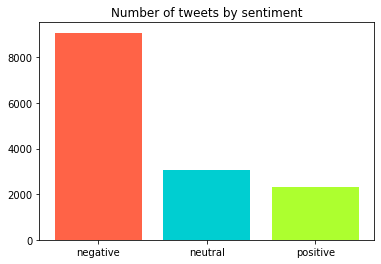

In [9]:
tweets_count= data['airline_sentiment'].value_counts()
print(tweets_count)

plt.bar(['negative','neutral','positive'],[tweets_count[0],tweets_count[1],tweets_count[2]],color=['tomato', 'darkturquoise', 'greenyellow'])
plt.title('Number of tweets by sentiment')
plt.show()

We see that the majority of tweets are tagged negative. 

### 3.b. Visualisation of the most frequent words by sentiment
What are the most frequent word used for each category of tweets ? 

In [10]:
from wordcloud import WordCloud,STOPWORDS

In [11]:
positive_tweets = data.loc[data.airline_sentiment =='positive']
positive_words = re.sub('@[^\s]+', '', ' '.join(positive_tweets['text']))
positive_wordcloud = WordCloud(background_color='white', width=600, height=600, margin=0).generate(positive_words)

negative_tweets = data.loc[data.airline_sentiment =='negative']
negative_words = re.sub('@[^\s]+', '', ' '.join(negative_tweets['text']))
negative_wordcloud = WordCloud(background_color='white',width=600, height=600, margin=0).generate(negative_words)

fig, ax = plt.subplots(1,2,figsize=(200,200))
ax[0].imshow(positive_wordcloud)
ax[0].title.set_text('Positive Tweets')
ax[1].imshow(negative_wordcloud)
ax[0].title.set_text('Negative Tweets')
plt.axis('on')
plt.show()

We can see that the 'positive' tweets are linked to good customer service, and 'negative' ones to cancelled and late flights.

### 3.c Sentiment and text length
The average word number of tweets, for each sentiment.

[66.83274609116934, 46.70055392636038, 48.3573264781491]


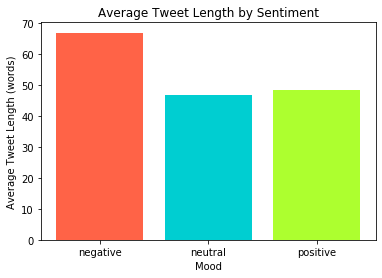

In [12]:
sentiments = ['negative','neutral','positive']
i = 0
avg = [0,0,0]
med = [0,0,0]
for sent in sentiments:
    avg[i] = data.loc[data.airline_sentiment == sent]['clean_text'].apply(len).mean()
    med[i] = data.loc[data.airline_sentiment == sent]['clean_text'].apply(len).median()
    i +=1
print(avg)
plt.bar([1,2,3],avg, color=['tomato', 'darkturquoise', 'greenyellow'])
# plt.bar([1,2,3],med, color=['tomato', 'darkturquoise', 'greenyellow'])
plt.xticks([1,2,3],['negative','neutral','positive'])
plt.ylabel('Average Tweet Length (words)')
plt.xlabel('Mood')
plt.title('Average Tweet Length by Sentiment')
plt.show()

In [13]:
# data.loc[data.airline_sentiment=='negative']['text']

We see that negative tweets tends to be longer than neutral and positive ones: people usually give more context to explain why they are disatisfied.

Let's now see the repartition of tweets' length by sentiment:

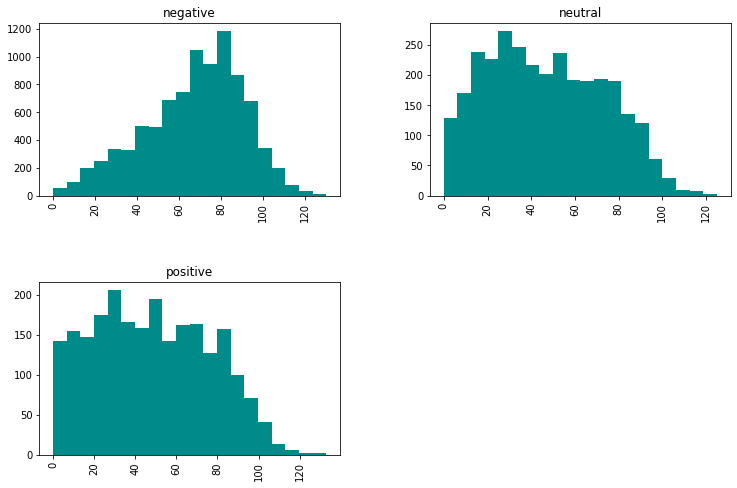

In [14]:
data.hist(column='length_text', by='airline_sentiment', color="darkcyan", bins=20, figsize=(12,8))
plt.show()

In [15]:
data.loc[data.airline_sentiment == 'negative'].describe()

airline_sentiment_confidence  length_text
count                   9082.000000  9082.000000
mean                       0.933260    66.832746
std                        0.138206    23.653853
min                        0.339400     0.000000
25%                        1.000000    52.000000
50%                        1.000000    70.000000
75%                        1.000000    84.000000
max                        1.000000   130.000000

We see that neutral and positive tweets are of more diversified in length, when over 75% of negative tweets are longer than 84 characters. 

## 4. First try with some supervized models
I've decided to first try 4 classifiers, which are suited for sentiment analysis : Naive Bayesian Model, AdaBoost, SVM, and KNeighbors.

### A. Naive Bayesian Model

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

NB Model import:

In [17]:
from sklearn.naive_bayes import MultinomialNB

Conversion of sentiment (str) into booleans. 'positive' is singled out, because it leads to a better acuracy than when it is the negative or the neutral ones.

In [18]:
data['sentiment']=data['airline_sentiment'].apply(lambda x: 0 if x=='positive' else 1)

Preparation of the training dataset :

In [19]:
X = data['clean_text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [20]:
train_clean_tweet=[]
for tweet in X_train:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in X_test:
    test_clean_tweet.append(tweet)

In [21]:
# print(train_features[0])

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

Model training and acuracy : 

In [23]:
mnb = MultinomialNB()
mnb.fit(train_features,y_train)
y_predictions = mnb.predict(test_features)
# print(accuracy_score(y_test,y_predictions))
mnb.score(train_features,y_train)

0.928776895639167

### B. SVM

In [24]:
from sklearn.svm import SVC

In [25]:
svc = SVC(gamma='auto')
svc.fit(train_features,y_train)
y_predictions = svc.predict(test_features)
# print(accuracy_score(y_test,y_predictions))
svc.score(train_features,y_train)

0.8398343113565757

### C. AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
ada = AdaBoostClassifier()
ada.fit(train_features,y_train)
y_predictions = ada.predict(test_features)
# print(accuracy_score(y_test,y_predictions))
ada.score(train_features,y_train)

0.8891957197100449

### D. Visual Comparison of the accuracies

#### a) With accuracy_score()

In [28]:
from sklearn.neighbors import KNeighborsClassifier

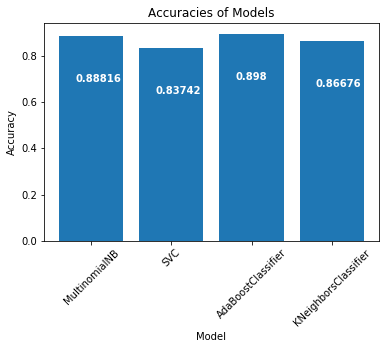

In [29]:
def test_models(train_features,y_train,test_features,y_test):
    accuracy = []
    model_index = []
    models = [MultinomialNB(), SVC(gamma='auto'), AdaBoostClassifier(),KNeighborsClassifier()]
    for model in models:
        fit = model.fit(train_features,y_train)
        pred = fit.predict(test_features)
        accuracy.append(accuracy_score(pred,y_test))
        model_index.append(model.__class__.__name__)
    Index = [k for k in range(1,len(model_index)+1)]
    plt.bar(Index,accuracy)
    plt.xticks(Index, model_index,rotation=45)
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.title('Accuracies of Models')
    for i, v in enumerate(accuracy):
        plt.text(i +0.8,v-0.2, np.around(v, decimals=5), color='white', fontweight='bold')
    plt.show()

test_models(train_features,y_train,test_features,y_test)
    

#### b) With a cross-validation

First we prepare the data.

In [ ]:
from sklearn.model_selection import cross_val_score

X = data['clean_text']
y = data['sentiment']

X_list=[]
for tweet in X:
    X_list.append(tweet)
    
v = CountVectorizer(analyzer = "word")
X_features= v.fit_transform(X_list)

The following function realizes a cross-validation with 5 folds for each of the chosen models.

In [93]:
def cross_test_models(X,y):
    scores = []
    avg_scores = []
    model_index = []
    models = [MultinomialNB(), SVC(gamma='auto'), AdaBoostClassifier(),KNeighborsClassifier()]
    for model in models:
        score = cross_val_score(model, X, y, scoring='f1',cv=5,error_score='raise')
        scores.append(score)
        avg_scores += [(np.mean(score))]
        model_index.append(model.__class__.__name__)
    Index = [k for k in range(1,len(model_index)+1)]
    plt.bar(Index,avg_scores)
    plt.xticks(Index, model_index,rotation=45)
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.title('Accuracies of Models')
    for i, v in enumerate(avg_scores):
        plt.text(i +0.8,v-0.2, np.around(v, decimals=5), color='white', fontweight='bold')
    plt.show()
    return scores

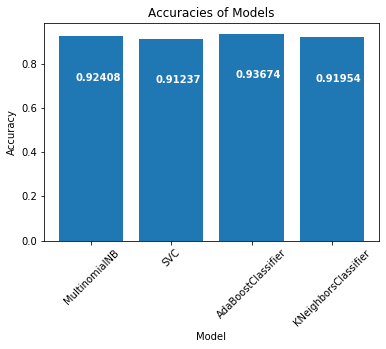

[array([0.91807278, 0.91447234, 0.9344558 , 0.93394901, 0.9194658 ]), array([0.9123663 , 0.9123334 , 0.9123334 , 0.9123334 , 0.91250469]), array([0.93303929, 0.93378812, 0.94490082, 0.94032258, 0.9316343 ]), array([0.91170431, 0.92394822, 0.92485315, 0.92068684, 0.91651357])]


In [94]:
print(cross_test_models(X_features,y))

The accuracy we obtain is better, but it can be improved.
For this first try, I've tried 4 supervized classifier, and I obtained a maximum accuracy of 0.94 for AdaBoost with cross validation. 
I will now try to better this result by changing the preprocessing of the text. 
I want to try to introduce bigrams and trigrams while tokenizing of the tweets with CountVectorizer in the scikit-learn module feature_extraction module.
I will also try to tokenize emojis.